# 1D testing STDP model network

http://www.scholarpedia.org/article/Spike-timing_dependent_plasticity

STDP can be seen as a spike-based formulation of a Hebbian learning rule. 

Two thalamic inputs are sent to two cells (one for each) such that there's a small time gap between the two inputs.

Two cells are excitatory and the synapse from the first cells to the second is modelled with STDP.

In [31]:
# fileName

fileName = 'eg_testing-STDP-model-network'

In [32]:
# libs

import pyNN.spiNNaker as sim
from pyNN import space 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
# simulation settings

sim.setup(
        timestep=1, # [ms]
        min_delay=1, # [ms]
        max_delay=100) # [ms]

simtime = 125 # [ms+]



2023-03-17 10:23:03 INFO: Read cfg files: /home/spinnaker/sPyNNaker/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg, /home/spinnaker/sPyNNaker/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg, /home/spinnaker/.spynnaker.cfg
2023-03-17 10:23:03 INFO: Will search these locations for binaries: /home/spinnaker/sPyNNaker/lib/python3.6/site-packages/spinn_front_end_common/common_model_binaries : /home/spinnaker/sPyNNaker/lib/python3.6/site-packages/spynnaker/pyNN/model_binaries
2023-03-17 10:23:03 WARNING: /home/spinnaker/CNT-2023/SpiNNaker/reports has 38 old reports that have not been closed
2023-03-17 10:23:03 WARNING: /home/spinnaker/CNT-2023/SpiNNaker/application_generated_data_files has 38 old reports that have not been closed
2023-03-17 10:23:03 INFO: Setting time scale factor to 1.
2023-03-17 10:23:03 INFO: Setting machine time step to 1000 micro-seconds.


['/home/spinnaker/sPyNNaker/lib/python3.6/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/spinnaker/sPyNNaker/lib/python3.6/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/spinnaker/.spynnaker.cfg']


## make the network

In [34]:
# define make_pop

pops = {}

pops['pre'] = sim.Population(
                        1, # one cell in each cell model
                        sim.IF_curr_exp,
                        cellparams=sim.IF_curr_exp.default_initial_values, # std pars used
                        structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0),
                        initial_values=None,
                        label='network',
                        constraints=None,
                        additional_parameters=None,
                        )
                        
pops['post'] = sim.Population(
                        1, # one cell in each cell model
                        sim.IF_curr_exp,
                        cellparams=sim.IF_curr_exp.default_initial_values, # std pars used
                        structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0),
                        initial_values=None,
                        label='network',
                        constraints=None,
                        additional_parameters=None,
                        )

pops['pre'].record(['spikes', 'v', 'gsyn_exc', 'gsyn_inh'])
pops['post'].record(['spikes', 'v', 'gsyn_exc', 'gsyn_inh'])



pops.keys()

2023-03-17 10:23:03 WARNING: Formal PyNN specifies that v should be set using initial_values not cell_params
2023-03-17 10:23:03 WARNING: Formal PyNN specifies that isyn_exc should be set using initial_values not cell_params
2023-03-17 10:23:03 WARNING: Formal PyNN specifies that isyn_inh should be set using initial_values not cell_params
2023-03-17 10:23:03 WARNING: Formal PyNN specifies that v should be set using initial_values not cell_params
2023-03-17 10:23:03 WARNING: Formal PyNN specifies that isyn_exc should be set using initial_values not cell_params
2023-03-17 10:23:03 WARNING: Formal PyNN specifies that isyn_inh should be set using initial_values not cell_params


dict_keys(['pre', 'post'])

## make the thalamic input stimulus

In [35]:
pops['thalamus-pre'] = sim.Population(1, 
                            sim.SpikeSourceArray([30, 40, 50, 60, 70, 80, 90]),
                            structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0),
                            )    

pops['thalamus-post'] = sim.Population(1, 
                             sim.SpikeSourceArray([32, 42, 52, 62, 72, 82, 92]),
                             structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0))

pops['thalamus-post'].record('spikes')
pops['thalamus-pre'].record('spikes')


pops.keys()

dict_keys(['pre', 'post', 'thalamus-pre', 'thalamus-post'])

## make learning rule between pre and post syn cells

In [36]:
timing = sim.SpikePairRule(tau_plus=10.0, 
                           tau_minus=1.0, 
                           A_plus=0.5, 
                           A_minus=0.5)

weight = sim.AdditiveWeightDependence(w_max=5.0, w_min=0.0) # range of learnig #nA

starting_weight = 0.1 # uS
projs = {}
projs['pre', 'post'] = sim.Projection(pops['pre'], pops['post'], 
                                      sim.OneToOneConnector(), 
                                      sim.STDPMechanism(
                                          timing_dependence=timing, 
                                          weight_dependence=weight, 
                                          weight=starting_weight, 
                                          delay=5.0))

projs.keys()

dict_keys([('pre', 'post')])

## make the thalamic - pops projections

In [37]:
projs['thalamus-pre', 'pre'] = sim.Projection(
                                    pops['thalamus-pre'],
                                    pops['pre'],
                                    sim.OneToOneConnector(),
                                    synapse_type=sim.StaticSynapse(weight=5),#, delay=None),
                                    receptor_type = 'excitatory',
                                    space = space.Space(axes = 'x'),
                                    label=None,
                                )


projs['thalamus-post', 'post'] = sim.Projection(
                                    pops['thalamus-post'],
                                    pops['post'],
                                    sim.OneToOneConnector(),
                                    synapse_type=sim.StaticSynapse(weight=5),#, delay=1.0),
                                    receptor_type = 'excitatory',
                                    space = space.Space(axes = 'x'),
                                    label=None,
                                )



projs.keys()

dict_keys([('pre', 'post'), ('thalamus-pre', 'pre'), ('thalamus-post', 'post')])

## run the simulation

In [38]:
sim.run(simtime) 

2023-03-17 10:23:03 INFO: Simulating for 125 1.0ms timesteps using a hardware timestep of 1000us
2023-03-17 10:23:03 INFO: Starting execution process
2023-03-17 10:23:07 INFO: Time 0:00:03.148789 taken by SpallocMaxMachineGenerator
Pre allocating resources for Extra Monitor support vertices
|0%                          50%                         100%|
2023-03-17 10:23:16 INFO: Time 0:00:09.124047 taken by PreAllocateResourcesForExtraMonitorSupport
Partitioning graph vertices
|0%                          50%                         100%|
Partitioning graph edges
|0%                          50%                         100%|
2023-03-17 10:23:21 INFO: Time 0:00:04.988478 taken by PartitionAndPlacePartitioner
Created spalloc job 7076729
2023-03-17 10:23:21 INFO: Created spalloc job 7076729
Waiting for board power commands to complete.
2023-03-17 10:23:21 INFO: Waiting for board power commands to complete.
2023-03-17 10:23:26 INFO: Time 0:00:05.050873 taken by SpallocAllocator
2023-03-17 1

125.0

## save results

In [39]:
# save the results

outputs = {}

for syn in ['pre', 'post', 'thalamus-pre', 'thalamus-post']:
    
    outputs[syn] = pops[syn].get_data()
    
    for recording in ['v', 'gsyn_inh', 'gsyn_exc', 'spikes']:
        pops[syn].write_data(fileName + '_' + str(recording) + '.pkl')


Getting spikes for network
|0%                          50%                         100%|
Getting v for network
|0%                          50%                         100%|
Getting gsyn_exc for network
|0%                          50%                         100%|
Getting gsyn_inh for network
|0%                          50%                         100%|
Getting spikes for network
|0%                          50%                         100%|
Getting v for network
|0%                          50%                         100%|
Getting gsyn_exc for network
|0%                          50%                         100%|
Getting gsyn_inh for network
|0%                          50%                         100%|
Getting spikes for network
|0%                          50%                         100%|
Getting v for network
|0%                          50%                         100%|
Getting gsyn_exc for network
|0%                          50%                         100%|
Getting gsyn_in

## recover results

In [40]:
# make the recover results function
def recover_results(outputs):
    results = {}
    for key in outputs.keys(): 
        
        # to get voltage and conductances
        for analogsignal in outputs[key].segments[0].analogsignals:
            print(analogsignal.name)
            results[key, analogsignal.name] = analogsignal

        # to get spikes
        results[key, 'spikes'] = outputs[key].segments[0].spiketrains
    return results

# recover results
results = recover_results(outputs)
results.keys()

v
gsyn_exc
gsyn_inh
v
gsyn_exc
gsyn_inh


dict_keys([('pre', 'v'), ('pre', 'gsyn_exc'), ('pre', 'gsyn_inh'), ('pre', 'spikes'), ('post', 'v'), ('post', 'gsyn_exc'), ('post', 'gsyn_inh'), ('post', 'spikes'), ('thalamus-pre', 'spikes'), ('thalamus-post', 'spikes')])

## check the spikes

Text(27.125, 0.5, 'cells ID')

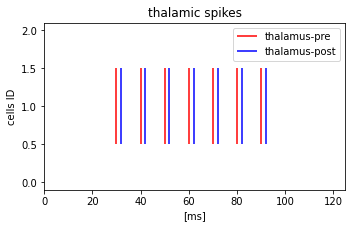

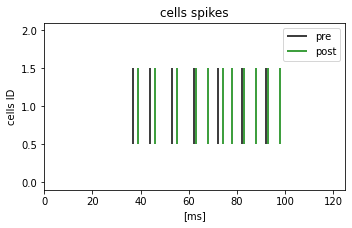

In [41]:
fig, axes = plt.subplots(1,1)
fig.tight_layout(pad=5)
axes_list = fig.axes


axes_list[0].eventplot(results['thalamus-pre', 'spikes'], label='thalamus-pre', color='r')
axes_list[0].eventplot(results['thalamus-post', 'spikes'], label='thalamus-post', color='b')
axes_list[0].set_title('thalamic spikes')
axes_list[0].set_xlabel('[ms]')
axes_list[0].set_ylabel('cells ID')
axes_list[0].set_xlim(0,simtime)
#axes_list[0].set_ylim(0,2)
axes_list[0].legend()


fig, axes = plt.subplots(1,1)
fig.tight_layout(pad=5)
axes_list = fig.axes
axes_list[0].eventplot(results['pre', 'spikes'], label='pre', color='k')
axes_list[0].eventplot(results['post', 'spikes'], label='post', color='g')
axes_list[0].set_xlabel('[ms]')
axes_list[0].set_title('cells spikes')
axes_list[0].set_xlim(0,simtime)
axes_list[0].legend()
axes_list[0].set_xlabel('[ms]')
axes_list[0].set_ylabel('cells ID')




In [48]:
%pip list

Package                     Version
--------------------------- ---------
aedat                       1.0.1
appdirs                     1.4.4
attrs                       19.3.0
backcall                    0.2.0
bleach                      3.1.5
Brian2                      2.4.2
cached-property             1.5.2
certifi                     2020.6.20
chardet                     3.0.4
csa                         0.1.12
cycler                      0.10.0
Cython                      0.29.33
decorator                   4.4.2
defusedxml                  0.6.0
Deprecated                  1.2.13
entrypoints                 0.3
enum-compat                 0.0.3
enum34                      1.1.10
future                      0.18.2
h5py                        3.1.0
idna                        2.9
importlib-metadata          1.6.1
ipykernel                   5.3.0
ipympl                      0.5.6
ipython                     7.15.0
ipython-genutils            0.2.0
ipywidgets                  7.5.1

## check the voltage signature

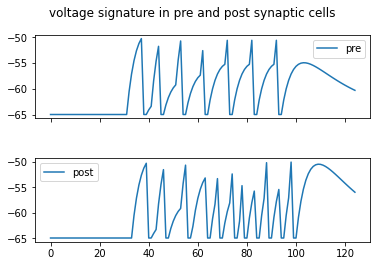

In [42]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)#, figsize=(11,7))
fig.tight_layout(pad=3)
fig.suptitle('voltage signature in pre and post synaptic cells')

axes_list = fig.axes
for idx, syn in enumerate(['pre', 'post']):
    axes_list[idx].plot(results[syn, 'v'], label=str(syn))
    axes_list[idx].legend()

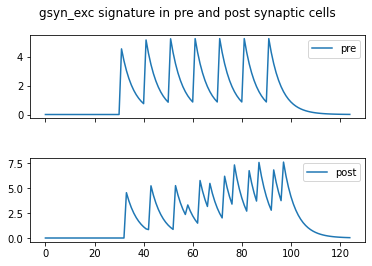

In [43]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)#, figsize=(11,7))
fig.tight_layout(pad=3)
fig.suptitle('gsyn_exc signature in pre and post synaptic cells')

axes_list = fig.axes
idx = 0
for idx, syn in enumerate(['pre', 'post']):
    axes_list[idx].plot(results[syn, 'gsyn_exc'], label=str(syn))
    axes_list[idx].legend()

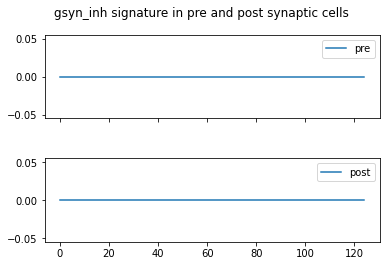

In [44]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)#, figsize=(11,7))
fig.tight_layout(pad=3)
fig.suptitle('gsyn_inh signature in pre and post synaptic cells')

axes_list = fig.axes
idx = 0
for idx, syn in enumerate(['pre', 'post']):
    axes_list[idx].plot(results[syn, 'gsyn_inh'], label=str(syn))
    axes_list[idx].legend()

## check the STDP between pre and post cells

In [45]:
projs.keys()
#projs['pre', 'post'].get(['source', 'target', 'weight', 'delay'], "list")
print('starting weight pre stdp: ', starting_weight, ' [uS]')
projs['pre', 'post'].getWeights()

2023-03-17 10:24:01 WARNING: getWeights is deprecated.  Use get('weight') instead
Getting ['weight']s for projection between network and network1
|0%                          50%                         100%|

starting weight pre stdp:  0.1  [uS]


array([5.])

In [46]:
print('final weight after stdp: ', projs['pre', 'post'].getWeights(), ' [uS]')

# the weight between pre and post neuron was set to zero before the learning, now it's ..

2023-03-17 10:24:01 WARNING: getWeights is deprecated.  Use get('weight') instead
Getting ['weight']s for projection between network and network1
|0%                          50%                         100%|

final weight after stdp:  [5.]  [uS]


## end the simulations

In [47]:
sim.end()

# task1: on thalamus input spike times
- test different interspike timing <br>
  e.g., <br>
    a=np.arange(0,100,10) for the thalamus-pre <br>
    a+15 for the thalamus post <br>
    
- test only one spike source eliciting the pre synaptic cell<br>
  remember to set the starting weight > 0, otherwise the post synaptic doesn't learn

# task2: on STDP mechanism
- try to change the parameter inside the SpikePairRule

